In [1]:
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import KFold, GridSearchCV

from side_info_decoding.utils import set_seed, load_data_from_pids

seed = 666
set_seed(seed)

### Functionality

In [141]:
def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    corr = pearsonr(y_true.flatten(), y_pred.flatten())[0]
    return r2, corr

def continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False, verbose=True):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]
    
    train_K, test_K = len(train_X), len(test_X)
    _, C, T = train_X.shape
    if time_independent:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
        train_Y = train_Y.reshape((-1))
        test_Y = test_Y.reshape((-1))
        if verbose:
            print("time-independent:")
    else:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, T*C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, T*C))
        if verbose:
            print("time-dependent:")
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    if time_independent:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    else:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
        
    if verbose:
        print(f"r2: {r2:.3f} corr: {corr:.3f}")
    
    return pred_Y, [r2, corr]

def sliding_window_over_time(data, half_window_size=3):
    
    window_size = 2*half_window_size + 1
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - 2*half_window_size, window_size
        ))
        for t in range(n_t_bins - 2*half_window_size):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t + d]
            data_window[:,:,t] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        max_len = n_t_bins - 2*half_window_size
        data_window = np.zeros((n_trials, max_len, window_size))
        for t in range(max_len):
            data_window[:,t] = data[:,t:t+window_size]
        data_window = data_window[:,:,half_window_size]
    return data_window

def sliding_window_decoder(train_X, train_Y, test_X, test_Y, verbose=True):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]
    
    train_K, C, T, L = train_X.shape
    test_K, _, _, _ = test_X.shape
    
    train_X = train_X.transpose(0,1,-1,2).reshape(train_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    test_X = test_X.transpose(0,1,-1,2).reshape(test_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    if verbose:
        print("sliding-window:")
        print(f"r2: {r2:.3f} corr: {corr:.3f}")
    
    return pred_Y, [r2, corr]

In [2]:
class ReducedRankRegression(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(ReducedRankRegression, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1,))
        
    def forward(self, x):
        self.beta = self.U @ self.V
        out = torch.einsum("ct,kct->kt", self.beta, x)
        out += self.b
        return out
    
def train_rrr(
    X, 
    Y, 
    train,
    test,
    n_r = 10,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    rrr = ReducedRankRegression(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(rrr.parameters(), lr=learning_rate, weight_decay=1e-3)
    criterion = torch.nn.MSELoss()
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train RRR:"):
        optimizer.zero_grad()
        y_pred = rrr(train_x)
        loss = criterion(y_pred, train_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return rrr, losses

### Load Data

In [129]:
neural_data = np.load("neural_data.npy", allow_pickle=True).item()
behavior_data = np.load("behavior_data.npy", allow_pickle=True).item()
print(neural_data.keys())
print(behavior_data.keys())

dict_keys(['po', 'lp', 'dg', 'ca1', 'vis'])
dict_keys(['wheel_speed', 'motion_energy', 'pupil_diameter', 'paw_speed'])


In [130]:
X, Y = neural_data["po"], behavior_data["motion_energy"]
K, C, T = X.shape
print(X.shape)
print(Y.shape)

(367, 159, 50)
(367, 50)


In [131]:
# data preprocessing
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
)
smooth_Y = np.array([gaussian_filter1d(Y[k, :], 4) for k in range(K)])
norm_Y = smooth_Y / smooth_Y.max() # to prevent gradient explosion

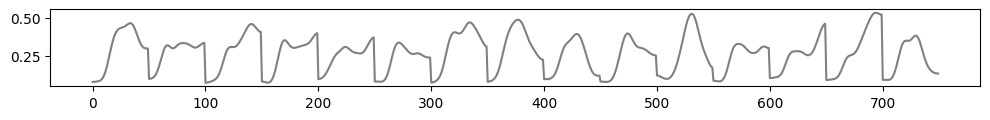

In [132]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[10:10+15].flatten(), c="gray")
plt.show()

### Find time offset for each brain region

In [137]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [ ]:
# this code takes a long time to run
time_lag = {}
for l in np.arange(11):
    print(f"time lag = {l*20} ms")
    window_X = sliding_window_over_time(smooth_X, half_window_size=l)
    window_Y = sliding_window_over_time(norm_Y, half_window_size=l)
    mean_r2 = []
    for train, test in kf.split(smooth_X):
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]
        _, metrics = sliding_window_decoder(train_X, train_Y, test_X, test_Y, verbose=False)
        mean_r2.append(metrics[0])
    print(f"5-fold CV R2 = {np.mean(mean_r2):.3f}")
    time_lag.update({l: np.mean(mean_r2)})

In [195]:
best_lag = max(time_lag, key=time_lag.get)
print(f"best time lag is {best_lag*20} ms.")

best time lag is 40 ms.


For the following analysis, use the same train and test set:

In [147]:
for train, test in kf.split(X):
    pass
print(test)

[  2   9  16  24  42  45  46  51  57  60  63  69  70  77  80  83  86  88
  91  99 100 102 103 107 112 122 126 139 141 142 147 148 151 155 156 161
 164 166 168 174 175 192 204 210 212 219 222 223 225 236 255 261 270 276
 277 282 283 290 292 294 295 301 318 322 325 328 329 333 338 342 348 355
 361]


#### Baseline

In [151]:
train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.715 corr: 0.846
time-dependent:
r2: 0.748 corr: 0.865


In [150]:
window_X = sliding_window_over_time(smooth_X, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

(367, 159, 46, 5)
sliding-window:
r2: 0.723 corr: 0.850


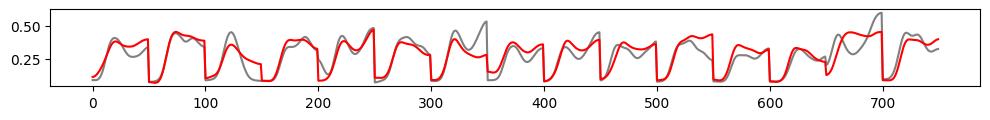

In [152]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

### Low-Rank Subspace

In [153]:
R = 15

rrr, losses = train_rrr(
    X = smooth_X,
    Y = norm_Y, 
    train = train,
    test = test,
    n_r = R,
    learning_rate = 5e-3,
    n_epochs = 10000
)

Train RRR:: 100%|█████████████████████████| 10000/10000 [02:39<00:00, 62.70it/s]


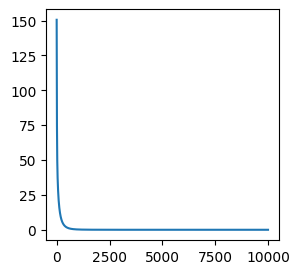

In [154]:
plt.figure(figsize=(3,3))
plt.plot(losses);

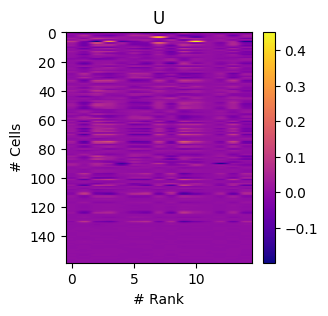

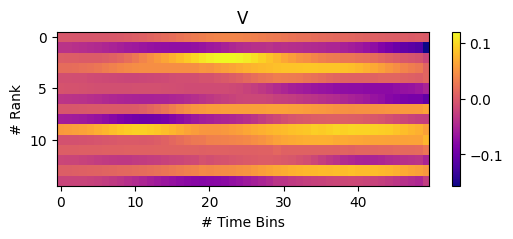

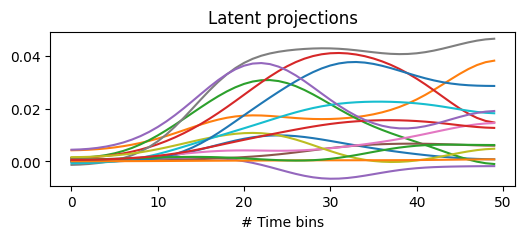

In [161]:
supervised_subspace = rrr.U.detach().numpy()
subspace_weights = rrr.V.detach().numpy()

plt.figure(figsize=(3,3))
plt.imshow(supervised_subspace, aspect="auto", cmap="plasma")
plt.title("U")
plt.xlabel("# Rank")
plt.ylabel("# Cells")
plt.colorbar()
plt.show()

plt.figure(figsize=(6,2))
plt.imshow(subspace_weights, aspect="auto", cmap="plasma")
plt.title("V")
plt.xlabel("# Time Bins")
plt.ylabel("# Rank")
plt.colorbar()
plt.show()

all_proj = smooth_X.transpose(0,-1,1) @ supervised_subspace
weighted_proj = all_proj * subspace_weights.T
smooth_proj = np.array(
    [[gaussian_filter1d(weighted_proj[k, :, r], 4) for r in range(R)] for k in range(K)]
)

plt.figure(figsize=(6,2))
plt.plot(smooth_proj.mean(0).T)
plt.title("Latent projections")
plt.xlabel("# Time bins")
plt.show()

decode with maximally demixed latents

In [156]:
train_X, test_X = smooth_proj[train], smooth_proj[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.742 corr: 0.862
time-dependent:
r2: 0.749 corr: 0.866


In [157]:
window_X = sliding_window_over_time(smooth_proj, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.737 corr: 0.859


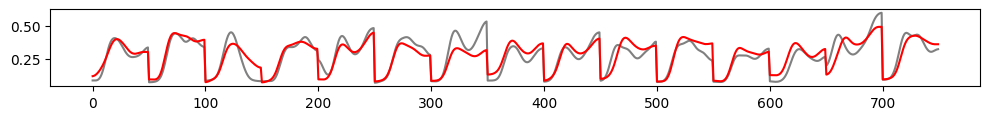

In [159]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

### PSID

In [164]:
# !pip install PSID --upgrade
import PSID
from PSID.evaluation import evalPrediction

In [191]:
xTrain = [smooth_X[k].T for k in train]
xTest = [smooth_X[k].T for k in test]
yTrain = [norm_Y[k].reshape(-1,1) for k in train]
yTest = [norm_Y[k].reshape(-1,1) for k in test]
xAll = [smooth_X[k].T for k in range(K)]

In [165]:
idSys = PSID.PSID(xTrain, yTrain, nx=15, n1=10, i=10)

In [192]:
yPred, xPred, zPred = [], [], []
for k in range(K):
    y, x, z = idSys.predict(xAll[k])
    yPred.append(y)
    xPred.append(x)
    zPred.append(z)
yPred = np.array(yPred).squeeze()
xPred = np.array(xPred)
zPred = np.array(zPred)

In [189]:
print(f"decoding R2: \
    {evalPrediction(np.concatenate(yTest), np.concatenate(yPred[test]), 'R2')[0]:.3f}"
)

decoding R2:     0.583


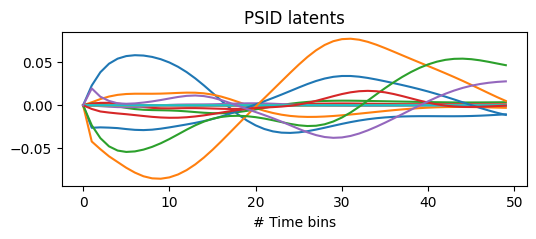

In [169]:
plt.figure(figsize=(6,2))
plt.plot(zPred.mean(0))
plt.title("PSID latents")
plt.xlabel("# Time bins")
plt.show()

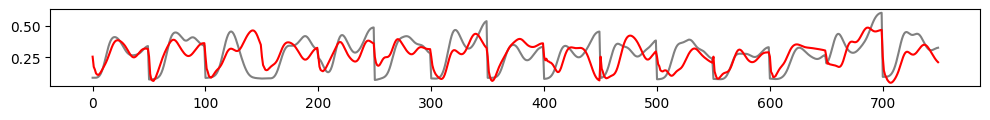

In [170]:
yTest = np.array(yTest).squeeze()
plt.figure(figsize=(12,1))
plt.plot(yTest[10:10+15].flatten(), c="gray")
plt.plot(yPred[10:10+15].flatten(), c="r")
plt.show()

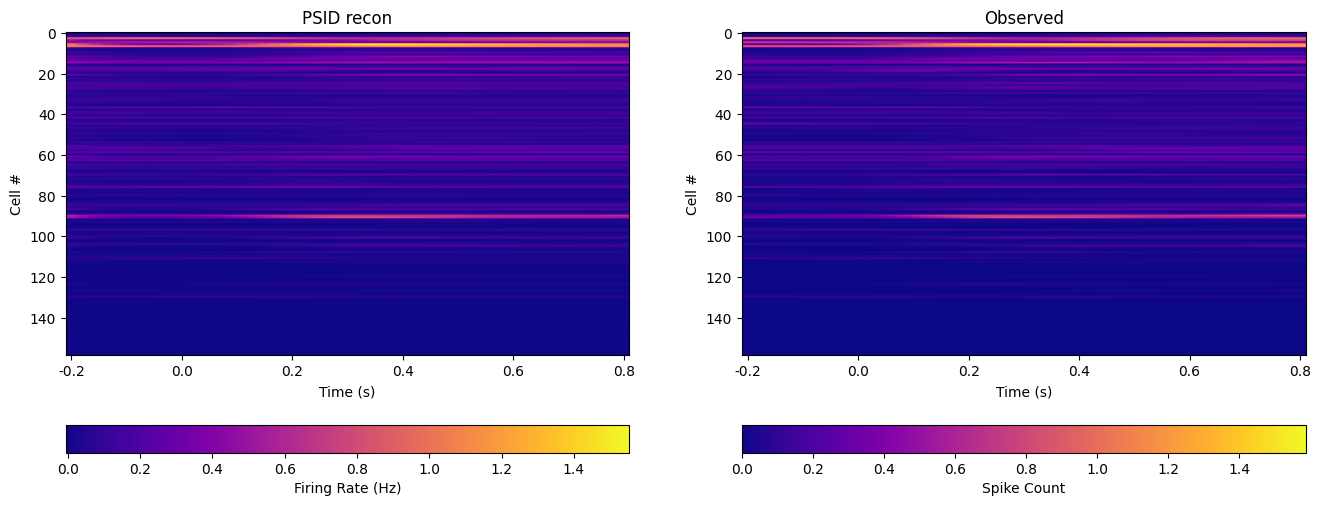

In [171]:
xTest = np.array(xTest)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
im1 = ax1.imshow(xPred.mean(0).T, aspect="auto", cmap=plt.cm.plasma)
ax1.set_xticks(np.linspace(0, 49, 6), ['%.1f'%i for i in np.linspace(-.2, .8, 6)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cell #')
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', label='Firing Rate (Hz)')
ax1.set_title('PSID recon')

im2 = ax2.imshow(xTest.mean(0).T, aspect="auto", cmap=plt.cm.plasma)
ax2.set_xticks(np.linspace(0, 49, 6), ['%.1f'%i for i in np.linspace(-.2, .8, 6)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cell #')
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', label='Spike Count')
ax2.set_title('Observed');

In [193]:
print(f"encoding R2: \
    {evalPrediction(np.concatenate(xTest).flatten(), np.concatenate(xPred[test]).flatten(), 'R2')[0]:.3f}"
)

encoding R2:     0.718


decode with PSID latents

In [177]:
zPred = zPred.transpose(0,-1,1)

train_X, test_X = zPred[train], zPred[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.576 corr: 0.762
time-dependent:
r2: 0.699 corr: 0.837


In [174]:
window_X = sliding_window_over_time(zPred, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.675 corr: 0.825


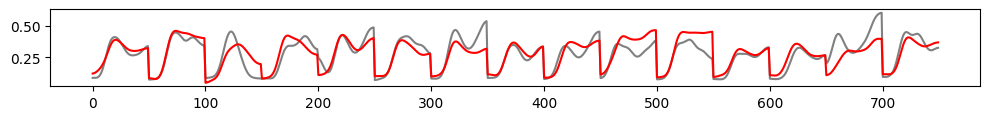

In [178]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

decode with PSID reconstructed firing rates

In [179]:
xPred = xPred.transpose(0,-1,1)

train_X, test_X = xPred[train], xPred[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.581 corr: 0.766
time-dependent:
r2: 0.712 corr: 0.848


In [182]:
window_X = sliding_window_over_time(xPred, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.680 corr: 0.828


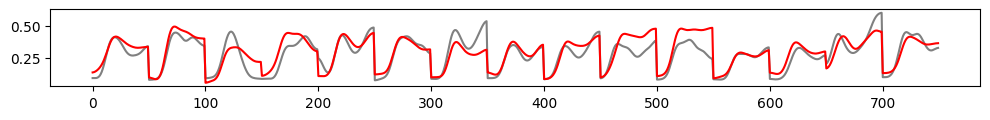

In [181]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

### LFADS